Navneet Kaur - 18110106 - Assignment 6-7

Secret Code - DEV

In [320]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import fsolve

1. Consider again Task 1 in the Midsem. Now, let us consider a straight line movement from point A = (0.40, 0.06, 0.1) to point B = (0.40, 0.01, 0.1). Either by making some reasonable/intuitive assumptions or using one of the approaches in the textbook come up with a desired trajectory to go from point A to point B. From this approach, generate the desired end-point trajectory (position, velocity, and acceleration). Plot trajectory for end-effector position, velocity and  acceleration with respect to time. Use this desired trajectory for all other tasks.

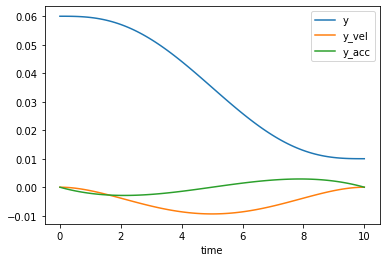

Text(0.5, 0, 'y')

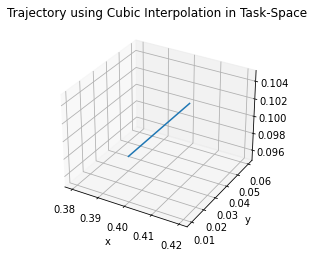

In [321]:
class trajectory_ef():

    def __init__(self, t0=0, tf=10, L=[1,1,1], t_step=100):
        self.t0 = t0
        self.tf = tf
        self.t_step = t_step
        self.y_vel = []
        self.y_acc = []
    
    def form_y_trajectory(self, start_pos, end_pos, b = True):
        T = np.array([
                        [1, self.t0, self.t0**2, self.t0**3, self.t0**4, self.t0**5],
                        [0, 1, 2*self.t0, 3*self.t0**2, 4*self.t0**3, 5*self.t0**4],
                        [0, 0, 2, 6*self.t0, 12*self.t0**2, 20*self.t0**3],
                        [1, self.tf, self.tf**2, self.tf**3, self.tf**4, self.tf**5],
                        [0, 1, 2*self.tf, 3*self.tf**2, 4*self.tf**3, 5*self.tf**4],
                        [0, 0, 2, 6*self.tf, 12*self.tf**2, 20*self.tf**3],
        ])
        Y = np.array([start_pos[1], 0, 0, end_pos[1], 0, 0])
        A = np.matmul(np.linalg.inv(T),Y)
        
        # x and z are constant 
        x = 0.40 * np.ones((self.t_step, 1))
        z = 0.1 * np.ones((self.t_step, 1))

        t = np.linspace(self.t0, self.tf, self.t_step).reshape(1,-1)
        a0 = A[0].reshape(1,-1).T
        a1 = A[1].reshape(1,-1).T
        a2 = A[2].reshape(1,-1).T
        a3 = A[3].reshape(1,-1).T
        a4 = A[4].reshape(1,-1).T
        a5 = A[5].reshape(1,-1).T
        y = a0 + a1@t + a2@t**2 + a3@t**3 + a4@t**4 + a5@t**5
        y_vel = a1 + 2*a2@t + 3*a3@t**2 + 4*a4@t**3 + 5*a5@t**4
        y_acc = 2*a2 + 6*a3@t + 12*a4@t**2 + 20*a5@t**3
        
        if b:
            plt.plot(t.T,y.reshape(1,-1).T)
            plt.plot(t.T,y_vel.reshape(1,-1).T)
            plt.plot(t.T,y_acc.reshape(1,-1).T)
            plt.legend(['y', 'y_vel', 'y_acc'])
            plt.xlabel('time')
            plt.show()
        self.y_vel = y_vel.reshape(1,-1).T
        self.y_acc = y_acc.reshape(1,-1).T
        return t.T, y.reshape(1,-1).T, x, z

    def get_vel_acc(self):
        return self.y_vel, self.y_acc

scara_ef = trajectory_ef(L = [0.25, 0.25, 0.25])
start_pos = [0.40, 0.06, 0.1]
end_pos = [0.40, 0.01, 0.1]
t, y, x, z = scara_ef.form_y_trajectory(start_pos, end_pos)
ax = plt.axes(projection='3d')
ax.plot3D(x[:,0], y[:,0], z[:,0])
plt.title('Trajectory using Cubic Interpolation in Task-Space')
plt.xlabel('x')
plt.ylabel('y')

2. Pick any one manipulator (your choice) out of Stanford, PUMA, and SCARA. Using the dimensions worked out in Task 1.a of Mid-sem exam (tweak those numbers if need be), then work out the desired trajectories in joint space. Plot these joint trajectories with respect to time. Use this same manipulator for all other tasks.

Text(0, 0.5, 'q dd')

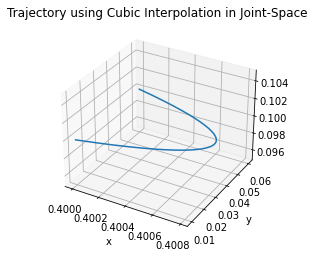

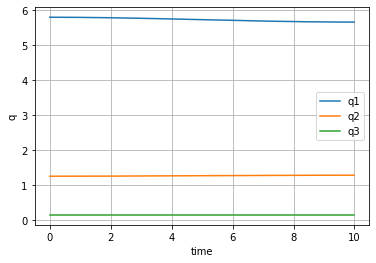

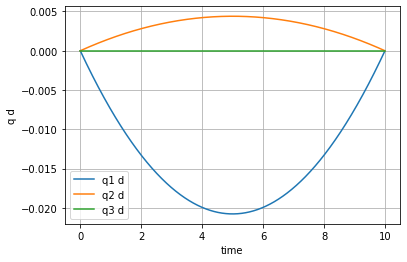

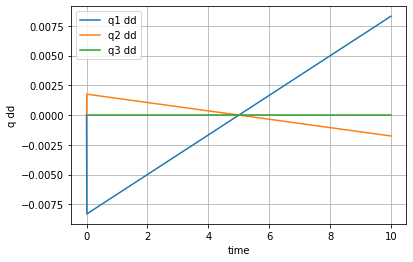

In [322]:
class trajectory_cubic():

    def __init__(self,  t0 = 0, tf = 10, L = [1,1,1], t_step = 1000):
        self.t0 = t0
        self.tf = tf
        self.q0 = []
        self.q0d = [0,0,0]
        self.q1 = []
        self.q1d = [0,0,0]
        self.L = L
        self.t_step = t_step

    def SCARA_IK(self,pos):
        l1 = self.L[1]
        l2 = self.L[2]
        d = pos

        def func_IK(theta):
            f =  [
                    l1*np.cos(theta[0]) + l2*np.cos(theta[0]+theta[1]) - d[0],
                    l1*np.sin(theta[0]) + l2*np.sin(theta[0]+theta[1]) - d[1],
            ]
            return f
            
        d4 = self.L[0] - d[2]
        t12 = fsolve(func_IK, [1,2])
        theta1 = (t12[0])%(2*np.pi)
        theta2 = (t12[1])%(2*np.pi)
        return [theta1, theta2, d4]

    def inverseK(self,start_pos, end_pos):
        self.q0 = self.SCARA_IK(start_pos)
        self.q1 = self.SCARA_IK(end_pos)

    def cubic_interpolation(self,):
        T = np.array([
                        [1, self.t0, self.t0**2, self.t0**3],
                        [0, 1, 2*self.t0, 3*self.t0**2],
                        [1, self.tf, self.tf**2, self.tf**3],
                        [0, 1, 2*self.tf, 3*self.tf**2]
        ])
        X = np.vstack((self.q0, self.q0d, self.q1, self.q1d))
        A = np.matmul(np.linalg.inv(T),X)
        return A
    
    def trajectory_form(self,):
        del_t = (self.tf - self.t0)/self.t_step
        q_des = self.q0
        q_d = self.q0d
        q_dd = [0,0,0]
        t = [0,]
        A = self.cubic_interpolation()
        for i in range(1,self.t_step):
            t = np.vstack((t, t[i-1]+del_t))
            qi = A[0] + A[1]*t[i] + A[2]*t[i]**2 + A[3]*t[i]**3
            qid = A[1] + 2*A[2]*t[i] + 3*A[3]*t[i]**2
            qidd = 2*A[2] + 6*A[3]*t[i]
            q_des = np.vstack((q_des, qi))
            q_d = np.vstack((q_d, qid))
            q_dd = np.vstack((q_dd, qidd))
        return q_des, t, q_d, q_dd

    def SCARA_kin(self, q):
        L = self.L
        x = L[0]*np.cos(q[0]) + L[1]*np.cos(q[0]+q[1])
        y = L[0]*np.sin(q[0]) + L[1]*np.sin(q[0]+q[1])
        z = L[2] - q[2]
        return [x,y,z]

L = [0.25, 0.25, 0.25]
scara_c = trajectory_cubic(L = L)
start_pos = [0.40,0.06,0.1]
end_pos = [0.40, 0.01, 0.1]
scara_c.inverseK(start_pos, end_pos)

q, t, qd, qdd = scara_c.trajectory_form()

ef_pos = []

for i in range(0,len(q)):
    pos = scara_c.SCARA_kin(q[i])
    ef_pos.append(pos)
    

ef_pos = np.array(ef_pos)
ax = plt.axes(projection='3d')

plt.figure(1)
ax.plot3D(ef_pos[:,0], ef_pos[:,1], ef_pos[:,2])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory using Cubic Interpolation in Joint-Space')

plt.figure(2)
plt.plot(t, q[:,0])
plt.plot(t, q[:,1])
plt.plot(t, q[:,2])
plt.grid()
plt.legend(['q1', 'q2', 'q3'])
plt.xlabel('time')
plt.ylabel('q')

plt.figure(3)
plt.plot(t, qd[:,0])
plt.plot(t, qd[:,1])
plt.plot(t, qd[:,2])
plt.grid()
plt.legend(['q1 d', 'q2 d', 'q3 d'])
plt.xlabel('time')
plt.ylabel('q d')

plt.figure(4)
plt.plot(t, qdd[:,0])
plt.plot(t, qdd[:,1])
plt.plot(t, qdd[:,2])
plt.grid()
plt.legend(['q1 dd', 'q2 dd', 'q3 dd'])
plt.xlabel('time')
plt.ylabel('q dd')

3. Implement the four controllers listed below with the above desired trajectories and compare the results by plotting the desired x-coordinate with respect to time along with the actual x-coordinate of end-effector with respect to time for all four control choice (all superimposed on the same graph). Please label and provide legend for the plots. Show similar plots for y-coordinate of the end-effector with respect to time, and similarly x-y coordinates on x-y plane.

In [354]:
class SCARA_dynamics():

    def __init__(self, L=[1,1,1], M=[1,1,1]) -> None:
        self.L = L
        self.M = M
        self.I = [0, self.M[1]*self.L[1]**2/3, self.M[2]*self.L[2]**2/3]

    def inverse_kin(self,pos):
        x,y,z = pos
        if np.sqrt(x**2 + y**2)>self.L[2] + self.L[1]:
            print('Not within bounds')
            return [None, None, None]
        
        else:
            def func(thetas):
                T = [
                        -x + self.L[1]*np.cos(thetas[0]) + self.L[2]*np.cos(thetas[0]+thetas[1]),
                        -y + self.L[1]*np.sin(thetas[0]) + self.L[2]*np.sin(thetas[0]+thetas[1]),
                        -z + self.L[0] - thetas[2]
                ]
                T = [T[0][0], T[1][0], T[2][0]]
                # print(T)
                return T
            q = fsolve(func,[1,1,1])

            q[0] = q[0]%(2*np.pi)
            q[1] = q[1]%(2*np.pi)
        
        return q

    def forward_kin(self,q):
        x = self.L[1]*np.cos(q[0]) + self.L[2]*np.cos(q[0]+q[1])
        y = self.L[1]*np.sin(q[0]) + self.L[2]*np.sin(q[0]+q[1])
        z = self.L[0] - q[2]
        return [x,y,z]

    def dynamics(self,q, qd):
        g = 9.8
        alpha = self.I[0] + self.L[1]**2*(self.M[0]/4 + self.M[1] + self.M[2])
        beta = self.I[1] + self.I[2] + self.L[2]**2*(self.M[1]/4 +self.M[2]) 
        gamma = self.L[1]*self.L[2]*self.M[2] + self.L[1] * self.L[2]/2 * self.M[1]

        M_ = np.array([[alpha + beta + 2*gamma*np.cos(q[1]), beta + 2*gamma*np.cos(q[1]), 0],
                       [beta + 2*gamma*np.cos(q[1]), beta, 0],
                       [0, 0, self.M[2]]])

        C = np.array([[-gamma*np.sin(q[1])*qd[1], -gamma*np.sin(q[1])*(qd[1] + qd[0]), 0],
                      [gamma*np.sin(q[1])*qd[0], 0, 0],
                      [0, 0, 0]])
        G = np.transpose(np.array([0, 0, self.M[2]*g]))

        return alpha, beta, gamma, M_,C,G
    
    def return_data(self):
        return self.L,self.M,self.I


class PD_CONTROLLER():

    def __init__(self, gains = [[1,0.3],[0.65,0.1],[0.6,1]], K = 15) -> None:
        self.gains = np.array(gains)
        self.error_buffer = np.zeros((3,5))
        self.J_eff = 1
        self.B_eff = 1
        self.K = K

    def errors_sum(self):
        sum_list = []
        for i in range(len(self.error_buffer)):
            sum_list.append(np.sum(self.error_buffer))
        
        return np.array(sum_list)

    def calculate_tau(self, error, d, qd, qdd, M, C, G):
        self.error_buffer = np.hstack((self.error_buffer[:,1:], np.transpose([error])))
        tau1 = self.gains[:,0]*error + self.gains[:,1]*(self.error_buffer[:,-1] - self.error_buffer[:,-2])
        tau2 = (self.J_eff*qdd + self.B_eff*qd)/self.K
        tau3 = M@qdd + C@qd@qd + G
        if d==0:
            tau = tau1
        elif d==1:
            tau = tau1 + tau2
        elif d==2:
            tau = tau1 + tau2 + tau3
        else:
            tau = tau1 + tau2 + tau3
        return tau   


class scara_pd():
    def __init__(self) -> None:
        self.controller = PD_CONTROLLER()
        self.scara = SCARA_dynamics(L=[0.25,0.25,0.25])
        self.traj = trajectory_ef()
        self.L, self.M, self.I = self.scara.return_data()
        self.q = np.array([0,0,0])
        self.qd = np.array([0,0,0])
        self.qdd = np.array([0,0,0])
        self.EF_pos = self.scara.forward_kin(self.q)

    def solver(self, q_des, delt, qd_des, qdd_des, d):
        g = 9.8
        error = q_des - self.q
        alpha, beta, gamma, M_,C,G = self.scara.dynamics(self.q, self.qd)
        alpha_des, beta_des, gamma_des, M_des,C_des,G_des = self.scara.dynamics(q_des, qd_des)
        tau = self.controller.calculate_tau(error, d, qd_des, qdd_des, M_des, C_des, G_des)

        T1 = -gamma*np.sin(self.q[1])*self.qd[1]*self.qd[0] - gamma*np.sin(self.q[1])*(self.qd[1] + self.qd[0])*self.qd[1] + tau[0]
        T2 = gamma*np.sin(self.q[1])*self.qd[0]**2 + tau[1]
        T3 = tau[2] + self.M[2]*g

        T = np.transpose(np.array([T1, T2, T3]))

        K = T - np.matmul(C, np.transpose(self.qd))-G

        acc = np.matmul(np.linalg.inv(M_), K)

        self.qd = self.qd + acc*delt
        self.q = self.q + self.qd*delt + 1/2*acc*delt**2
        self.qdd = acc

        self.q[0] = self.q[0]%(2*np.pi)
        self.q[1] = self.q[1]%(2*np.pi)
        self.EF_pos = self.scara.forward_kin(self.q)
    
    def control(self, d):
        start_pos = [0.4,0.06,0.1]
        end_pos = [0.4,0.01,0.1]
        t, y, x, z = self.traj.form_y_trajectory(start_pos, end_pos, b = False)
        ef_pos = [x[0], y[0], z[0]]
        des_pos = [x[0], y[0], z[0]]

        self.q = self.scara.inverse_kin(ef_pos)
        self.q = np.array(self.q)
        self.EF_pos = self.scara.forward_kin(self.q)
        q_des = self.q.copy()
        qd_des_i = np.array([0,0,0])
        i = 1
        ef_pos = [x[0][0], y[0][0], z[0][0]]
        des_pos = [x[0][0], y[0][0], z[0][0]]
        while True:

            if i<len(t)-1:
                delt = t[i] - t[i-1]
                track_pos = self.scara.inverse_kin([x[i], y[i], z[i]])

                qd_des = (track_pos - q_des)/delt
                qdd_des = (qd_des - qd_des_i)/delt
                qd_des_i = qd_des
                q_des = np.array(track_pos)

                self.solver(track_pos, delt, qd_des, qdd_des, d)
                temp = self.EF_pos
                ef_pos = np.vstack((ef_pos,[temp[0], temp[1], temp[2]]))
                des_pos = np.vstack((des_pos, [x[i][0], y[i][0], z[i][0]]))

            else:
                break

            i+=1
        
        ef_pos = np.array(ef_pos)
        des_pos = np.array(des_pos)
        plt.figure(0)
        plt.plot(ef_pos[:,1])
        plt.plot(des_pos[:,1])
        plt.legend(['Ef y', 'desired y'])
        plt.grid()
        plt.figure(1)
        plt.plot(ef_pos[:,0])
        plt.plot(des_pos[:,0])
        plt.legend(['Ef x', 'desired x'])
        plt.grid()
        plt.figure(2)
        plt.plot(ef_pos[:,2])
        plt.plot(des_pos[:,2])
        plt.legend(['Ef z', 'desired z'])
        plt.grid()

3. a) PD control that might yield a small (but non-zero) steady-state error and a damping ratio close to 1. 

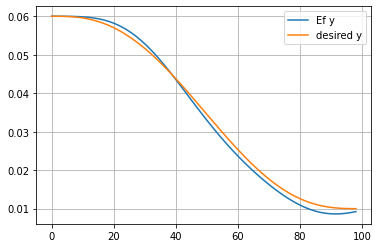

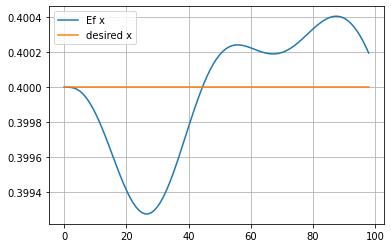

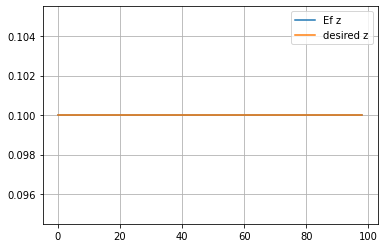

In [351]:
# Normal PD controller
s = scara_pd()
s.control(0)

3. b) Same PD control along with a feedforward control using motor dynamics (equation 7.6.6 in the textbook). 

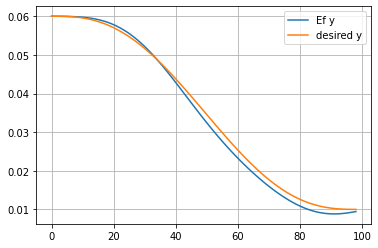

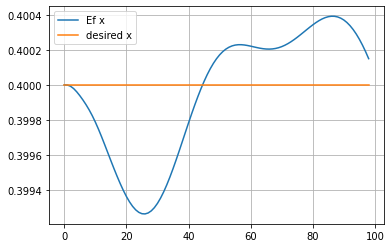

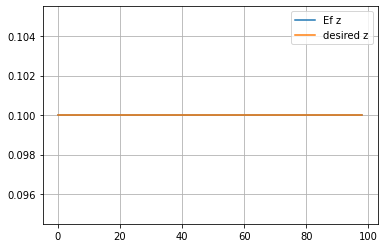

In [352]:
# PD controller with feedforward control
s = scara_pd()
s.control(1)

3. c) Same PD control along with a feedforward disturbance cancellation using computed torque method (equation 7.6.9 in the textbook). 

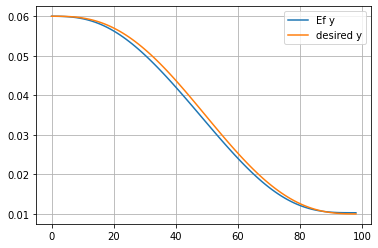

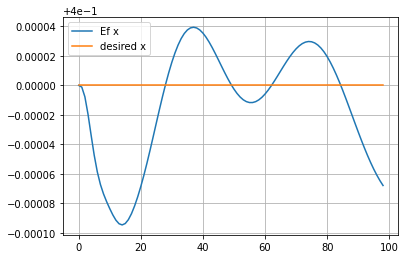

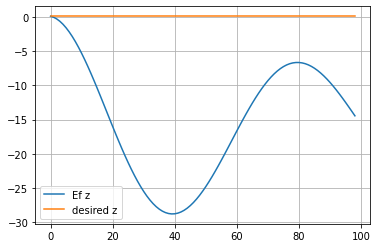

In [353]:
# PD controller with feedforward disturbance cancellation using computed torque method
s = scara_pd()
s.control(2)